<h1>Obiettivi dello studio</h1>

Si è svolta un'analisi complementare finalizzata al riconoscimento dei giocatori che potrebbero performare meglio in un ruolo diverso da quello loro assegnato.

In [58]:
import numpy as np
from io import StringIO
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from pandas.plotting import scatter_matrix
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy
import matplotlib as mlt



import random

#plotly imports
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn.preprocessing import StandardScaler

<h2>Caricamento del DataSet</h2>

In [59]:
#carichiamo i vari dataset
pass1 = pd.read_csv("./DataSet/DataSet_Classificazione/serieA_1_passing.csv", index_col=0, thousands=",", decimal=".")
pass2 = pd.read_csv("./DataSet/DataSet_Classificazione/serieA_2_passing.csv", index_col=0, thousands=",", decimal=".")
shot1 = pd.read_csv("./DataSet/DataSet_Classificazione/serieA_1_shot.csv", index_col=0, thousands=",", decimal=".")
shot2 = pd.read_csv("./DataSet/DataSet_Classificazione/serieA_2_shot.csv", index_col=0, thousands=",", decimal=".")
poss1 = pd.read_csv("./DataSet/DataSet_Classificazione/possession1.csv", index_col=0, thousands=",", decimal=".")
poss2 = pd.read_csv("./DataSet/DataSet_Classificazione/possession2.csv", index_col=0, thousands=",", decimal=".")
def1 = pd.read_csv("./DataSet/DataSet_Classificazione/defense1.csv", index_col=0, thousands=",", decimal=".")
def2 = pd.read_csv("./DataSet/DataSet_Classificazione/defense2.csv", index_col=0, thousands=",", decimal=".")
misc1 = pd.read_csv("./DataSet/DataSet_Classificazione/misc_1.csv", index_col=0, thousands=",", decimal=".")
misc2 = pd.read_csv("./DataSet/DataSet_Classificazione/misc_2.csv", index_col=0, thousands=",", decimal=".")

In [60]:
pass_ = pd.concat([pass1, pass2],axis=0, sort=True)
shot = pd.concat([shot1, shot2], axis=0, sort=True)
poss = pd.concat([poss1, poss2], axis=0, sort=True)
def_ = pd.concat([def1, def2], axis=0,sort=True)
misc_ = pd.concat([misc1, misc2], axis=0,sort=True)



Unisco tutto in un unica tabella, prima di fare ciò eliminiamo gli indici duplicati

In [61]:
pass_ = pass_[~pass_.index.duplicated(keep='first')]
shot = shot[~shot.index.duplicated(keep='first')]
poss = poss[~poss.index.duplicated(keep='first')]
def_ = def_[~def_.index.duplicated(keep='first')]
misc_ = misc_[~misc_.index.duplicated(keep='first')]
misc_.info()
ruolo = misc_["Pos"]

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, Jeroen Zoet to Sergej MilinkoviÄ‡-SaviÄ‡
Data columns (total 23 columns):
2CrdY      594 non-null int64
90s        594 non-null float64
Age        594 non-null int64
Born       594 non-null int64
CrdR       594 non-null int64
CrdY       594 non-null int64
Crs        594 non-null int64
Fld        594 non-null int64
Fls        594 non-null int64
Int        594 non-null int64
Lost       593 non-null float64
Matches    594 non-null object
Nation     594 non-null object
OG         594 non-null int64
Off        594 non-null int64
PKcon      593 non-null float64
PKwon      593 non-null float64
Pos        594 non-null object
Recov      593 non-null float64
Squad      594 non-null object
TklW       594 non-null int64
Won        593 non-null float64
Won%       501 non-null float64
dtypes: float64(7), int64(12), object(4)
memory usage: 111.4+ KB


<h2>Preprocessing</h2>

Per non gestire troppi attribuiti in un'unica volta effettuiamo il preprocessing dei dataset di ogni statistica singolarmente, dopo di che uniamo tutti i dataset.

In [62]:
#inseriamo il valore minimo delle partite giocate da un giocatore
limitePresenze= 11

Alcune operazioni di preprocessing sono comuni ad ogni dataset:
1. Eliminiamo i portieri -> Non sono oggetto dell'analisi in quanto non cambiano ruolo ed hanno statistiche diverse rispetto agli altri ruoli.
2. Eliminiamo i giocatori con poche presenze -> Le statistiche per giocatori che hanno giocato poche partite non danno risultati attendibili.

<h4>Shooting</h4>

In [63]:
shot = pd.concat([shot,ruolo], axis=1, sort=True )
shot = shot[shot["90s"] > limitePresenze ] 
shot = shot[shot["Pos"] != "GK"] 

In [64]:
shot.head()

,90s,Age,Born,Dist,FK,G-xG,G/Sh,G/SoT,Gls,PK,PKatt,Sh,Sh/90,SoT,SoT%,SoT/90,Squad,np:G-xG,npxG,npxG/Sh,xG,Pos
Aaron Ramsey,12.1,29,1990,13.8,0.0,-3.0,0.09,0.20,2,0,0,23,1.90,10,43.5,0.83,Juventus,-3.0,5.0,0.22,5.0,MF
Achraf Hakimi,29.6,21,1998,16.3,2.0,2.4,0.18,0.47,7,0,0,38,1.28,15,39.5,0.51,Inter,2.4,4.6,0.12,4.6,DF
Adam MaruÅ¡iÄ‡,33.0,27,1992,14.5,0.0,0.0,0.07,0.17,2,0,0,27,0.82,12,44.4,0.36,Lazio,0.0,2.0,0.08,2.0,DF
Adam Ounas,13.3,23,1996,17.1,0.0,2.0,0.16,0.40,4,0,0,25,1.88,10,40.0,0.75,Crotone,2.0,2.0,0.08,2.0,"FW,MF"
Adama Soumaoro,19.5,28,1992,7.4,0.0,-0.2,0.14,0.50,1,0,0,7,0.36,2,28.6,0.10,Bologna,-0.2,1.2,0.17,1.2,DF


In [65]:
shot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, Aaron Ramsey to È˜tefan Radu
Data columns (total 22 columns):
90s        295 non-null float64
Age        295 non-null int64
Born       295 non-null int64
Dist       294 non-null float64
FK         294 non-null float64
G-xG       294 non-null float64
G/Sh       295 non-null float64
G/SoT      280 non-null float64
Gls        295 non-null int64
PK         295 non-null int64
PKatt      295 non-null int64
Sh         295 non-null int64
Sh/90      295 non-null float64
SoT        295 non-null int64
SoT%       295 non-null float64
SoT/90     295 non-null float64
Squad      295 non-null object
np:G-xG    294 non-null float64
npxG       294 non-null float64
npxG/Sh    294 non-null float64
xG         294 non-null float64
Pos        295 non-null object
dtypes: float64(13), int64(7), object(2)
memory usage: 53.0+ KB


Droppiamo le colonne che sicuramente non useremo per fare analisi

In [66]:
shot.drop(shot.columns.difference(['np:G-xG']), 1, inplace=True)

<h4>Passaggi</h4>

In [67]:
pass_ = pass_[pass_["90s"] > limitePresenze] 
pass_ = pass_[pass_["Pos"] != "GK"]

In [68]:
pass_.head()

,1/3,90s,A-xA,Age,Ast,Att,Att.1,Att.2,Att.3,Born,Cmp,Cmp%,Cmp%.1,Cmp%.2,Cmp%.3,Cmp.1,Cmp.2,Cmp.3,CrsPA,KP,PPA,Pos,PrgDist,Prog,Squad,TotDist,xA
Player,,,,,,,,,,,,,,,,,,,,,,,,,,,
Marvin Zeegelaar,37.0,19.3,-1.1,29,0,777.0,325.0,324.0,101.0,1990,604.0,77.7,83.7,83.0,53.5,272.0,269.0,54.0,9.0,10.0,12.0,DF,3676.0,65.0,Udinese,10454.0,1.1
Davide Zappacosta,23.0,22.7,0.7,28,2,1093.0,507.0,415.0,119.0,1992,876.0,80.1,90.5,82.2,52.9,459.0,341.0,63.0,10.0,12.0,20.0,DF,4499.0,52.0,Genoa,14391.0,1.3
Gabriele Zappa,56.0,26.6,1.4,20,4,1313.0,584.0,516.0,165.0,1999,1029.0,78.4,89.0,79.8,49.7,520.0,412.0,82.0,19.0,31.0,43.0,DF,7245.0,121.0,Cagliari,16978.0,2.6
Ashley Young,25.0,15.8,1.3,35,4,676.0,279.0,289.0,78.0,1985,551.0,81.5,95.0,81.0,60.3,265.0,234.0,47.0,10.0,29.0,27.0,DF,3131.0,49.0,Inter,9420.0,2.7
Maya Yoshida,52.0,25.3,1.3,31,2,1187.0,255.0,593.0,318.0,1988,1012.0,85.3,88.6,94.4,67.9,226.0,560.0,216.0,0.0,5.0,1.0,DF,6386.0,52.0,Sampdoria,23530.0,0.7


In [69]:
pass_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, Marvin Zeegelaar to Piotr ZieliÅ„ski
Data columns (total 27 columns):
1/3        294 non-null float64
90s        295 non-null float64
A-xA       294 non-null float64
Age        295 non-null int64
Ast        295 non-null int64
Att        294 non-null float64
Att.1      294 non-null float64
Att.2      294 non-null float64
Att.3      294 non-null float64
Born       295 non-null int64
Cmp        294 non-null float64
Cmp%       294 non-null float64
Cmp%.1     294 non-null float64
Cmp%.2     294 non-null float64
Cmp%.3     294 non-null float64
Cmp.1      294 non-null float64
Cmp.2      294 non-null float64
Cmp.3      294 non-null float64
CrsPA      294 non-null float64
KP         294 non-null float64
PPA        294 non-null float64
Pos        295 non-null object
PrgDist    294 non-null float64
Prog       294 non-null float64
Squad      295 non-null object
TotDist    294 non-null float64
xA         294 non-null float64
dtypes: float64(

In [70]:
pass_.drop(pass_.columns.difference(['KP','Prog', 'Cmp%', "CrsPA"]), 1, inplace=True)
pass_.rename(columns = {"Cmp%": "Cmp_PS%", "Prog": "ProgressivePasses"}, inplace= True)

<h4>Possession</h4>

In [71]:
poss = pd.concat([poss, ruolo], axis=1, sort=True )
poss = poss[poss["90s"] > limitePresenze] 
poss = poss[poss["Pos"] != "GK"]

In [72]:
poss.head()

,#Pl,1/3,90s,Age,Att,Att 3rd,Att Pen,Born,CPA,Carries,Def 3rd,Def Pen,Dis,Live,Megs,Mid 3rd,Mis,PrgDist,Prog,Prog.1,Rec,Rec%,Squad,Succ,Succ%,Targ,TotDist,Touches,Pos
Aaron Ramsey,12.0,22.0,12.1,29,19.0,352.0,71.0,1990,9.0,619.0,122.0,17.0,10.0,840.0,1.0,446.0,24.0,1471.0,79.0,113.0,702.0,85.5,Juventus,12.0,63.2,821.0,3261.0,862.0,MF
Achraf Hakimi,40.0,51.0,29.6,21,67.0,867.0,137.0,1998,36.0,1255.0,389.0,50.0,33.0,1645.0,8.0,716.0,44.0,4411.0,221.0,163.0,1296.0,86.5,Inter,36.0,53.7,1499.0,6621.0,1863.0,DF
Adam MaruÅ¡iÄ‡,28.0,49.0,33.0,27,54.0,550.0,66.0,1992,10.0,1216.0,605.0,111.0,23.0,1721.0,1.0,911.0,18.0,3968.0,160.0,107.0,1241.0,88.0,Lazio,27.0,50.0,1411.0,7369.0,1912.0,DF
Adam Ounas,48.0,42.0,13.3,23,68.0,288.0,48.0,1996,15.0,553.0,84.0,5.0,40.0,628.0,3.0,383.0,23.0,2133.0,79.0,71.0,497.0,77.9,Crotone,46.0,67.6,638.0,3371.0,660.0,"FW,MF"
Adama Soumaoro,3.0,4.0,19.5,28,3.0,32.0,10.0,1992,0.0,602.0,583.0,166.0,2.0,1045.0,0.0,553.0,4.0,1580.0,31.0,2.0,627.0,97.4,Bologna,3.0,100.0,644.0,3253.0,1110.0,DF


In [73]:
poss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, Aaron Ramsey to È˜tefan Radu
Data columns (total 29 columns):
#Pl        294 non-null float64
1/3        294 non-null float64
90s        295 non-null float64
Age        295 non-null int64
Att        294 non-null float64
Att 3rd    294 non-null float64
Att Pen    294 non-null float64
Born       295 non-null int64
CPA        294 non-null float64
Carries    294 non-null float64
Def 3rd    294 non-null float64
Def Pen    294 non-null float64
Dis        294 non-null float64
Live       294 non-null float64
Megs       294 non-null float64
Mid 3rd    294 non-null float64
Mis        294 non-null float64
PrgDist    294 non-null float64
Prog       294 non-null float64
Prog.1     294 non-null float64
Rec        294 non-null float64
Rec%       294 non-null float64
Squad      295 non-null object
Succ       294 non-null float64
Succ%      290 non-null float64
Targ       294 non-null float64
TotDist    294 non-null float64
Touches    294 non-nu

In [74]:
poss.drop(poss.columns.difference(['Succ', "Prog"]), 1, inplace=True)
poss["Succ"].fillna(0,inplace=True)

<h4>Miscellaneus</h4>

In [75]:
misc_ = misc_[misc_["90s"] > limitePresenze] 
misc_ = misc_[misc_["Pos"] != "GK"]

In [76]:
misc_.head()

,2CrdY,90s,Age,Born,CrdR,CrdY,Crs,Fld,Fls,Int,Lost,Matches,Nation,OG,Off,PKcon,PKwon,Pos,Recov,Squad,TklW,Won,Won%
Player,,,,,,,,,,,,,,,,,,,,,,,
Marvin Zeegelaar,0,19.3,29,1990,0,6,34,7,39,14,26.0,Matches,nl NED,0,4,1.0,0.0,DF,134.0,Udinese,26,32.0,55.2
Davide Zappacosta,0,22.7,28,1992,0,3,67,19,23,16,17.0,Matches,it ITA,0,8,0.0,0.0,DF,153.0,Genoa,19,12.0,41.4
Gabriele Zappa,0,26.6,20,1999,0,3,69,11,25,26,35.0,Matches,it ITA,0,1,0.0,0.0,DF,199.0,Cagliari,23,12.0,25.5
Ashley Young,0,15.8,35,1985,0,4,36,15,13,9,8.0,Matches,eng ENG,0,3,1.0,0.0,DF,83.0,Inter,9,5.0,38.5
Maya Yoshida,0,25.3,31,1988,0,5,0,21,16,42,27.0,Matches,jp JPN,0,0,0.0,0.0,DF,259.0,Sampdoria,15,60.0,69.0


In [77]:
misc_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, Marvin Zeegelaar to Sergej MilinkoviÄ‡-SaviÄ‡
Data columns (total 23 columns):
2CrdY      296 non-null int64
90s        296 non-null float64
Age        296 non-null int64
Born       296 non-null int64
CrdR       296 non-null int64
CrdY       296 non-null int64
Crs        296 non-null int64
Fld        296 non-null int64
Fls        296 non-null int64
Int        296 non-null int64
Lost       295 non-null float64
Matches    296 non-null object
Nation     296 non-null object
OG         296 non-null int64
Off        296 non-null int64
PKcon      295 non-null float64
PKwon      295 non-null float64
Pos        296 non-null object
Recov      295 non-null float64
Squad      296 non-null object
TklW       296 non-null int64
Won        295 non-null float64
Won%       295 non-null float64
dtypes: float64(7), int64(12), object(4)
memory usage: 55.5+ KB


In [78]:
misc_.drop(misc_.columns.difference(['Won%']), 1, inplace=True)

<h4>Defense</h4>

In [79]:
def_ = pd.concat([def_, ruolo], axis=1, sort=True )
def_ = def_[def_["90s"] > limitePresenze] 
def_ = def_[def_["Pos"] != "GK"] 

In [80]:
def_.head()

,%,90s,Age,Att,Att 3rd,Att 3rd.1,Blocks,Born,Clr,Def 3rd,Def 3rd.1,Err,Int,Mid 3rd,Mid 3rd.1,Pass,Past,Press,Sh,ShSv,Squad,Succ,Tkl,Tkl%,Tkl+Int,Tkl.1,TklW,Pos
Aaron Ramsey,32.4,12.1,29,24.0,2.0,63.0,14.0,1990,9.0,8.0,54.0,1.0,6,14.0,108.0,12.0,19.0,225.0,2.0,0.0,Juventus,73.0,24.0,20.8,30.0,5.0,16,MF
Achraf Hakimi,29.0,29.6,21,56.0,8.0,147.0,40.0,1998,28.0,26.0,183.0,0.0,25,18.0,170.0,39.0,32.0,500.0,1.0,0.0,Inter,145.0,52.0,42.9,77.0,24.0,30,DF
Adam MaruÅ¡iÄ‡,30.1,33.0,27,41.0,3.0,53.0,56.0,1992,66.0,29.0,139.0,1.0,48,18.0,117.0,50.0,22.0,309.0,6.0,0.0,Lazio,93.0,50.0,46.3,98.0,19.0,28,DF
Adama Soumaoro,35.8,19.5,28,12.0,0.0,6.0,46.0,1992,99.0,23.0,129.0,0.0,32,5.0,80.0,20.0,6.0,215.0,26.0,0.0,Bologna,77.0,28.0,50.0,60.0,6.0,16,DF
Adrien Rabiot,29.7,25.7,25,57.0,11.0,85.0,46.0,1995,37.0,28.0,160.0,1.0,31,33.0,240.0,35.0,32.0,485.0,11.0,0.0,Juventus,144.0,72.0,43.9,103.0,25.0,45,MF


In [81]:
def_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, Aaron Ramsey to È˜tefan Radu
Data columns (total 28 columns):
%            294 non-null float64
90s          295 non-null float64
Age          295 non-null int64
Att          294 non-null float64
Att 3rd      294 non-null float64
Att 3rd.1    294 non-null float64
Blocks       294 non-null float64
Born         295 non-null int64
Clr          294 non-null float64
Def 3rd      294 non-null float64
Def 3rd.1    294 non-null float64
Err          294 non-null float64
Int          295 non-null int64
Mid 3rd      294 non-null float64
Mid 3rd.1    294 non-null float64
Pass         294 non-null float64
Past         294 non-null float64
Press        294 non-null float64
Sh           294 non-null float64
ShSv         294 non-null float64
Squad        295 non-null object
Succ         294 non-null float64
Tkl          294 non-null float64
Tkl%         294 non-null float64
Tkl+Int      294 non-null float64
Tkl.1        294 non-null float64
Tkl

In [82]:
def_.drop(def_.columns.difference(['TklW', "Int"]), 1, inplace=True)

-----------------------------------------------------------

Concateniamo tutte le tabelle con le varie statistiche in un unica tabella

In [83]:
dt = pd.concat([pass_, shot, poss, def_, misc_], axis=1, sort=True , join='inner')
dt.rename(columns ={"CrsPA":"Cross", "Prog":"ProgressiveCarries", "Succ":"Dribbling", "Int":"Interceptions", "TklW":"TackleWon", "Won%":"ADwon%"}, inplace=True)
dt.head()

,Cmp_PS%,Cross,KP,ProgressivePasses,np:G-xG,ProgressiveCarries,Dribbling,Interceptions,TackleWon,ADwon%
Aaron Ramsey,85.5,4.0,30.0,59.0,-3.0,79.0,12.0,6,16,30.4
Achraf Hakimi,82.5,21.0,36.0,124.0,2.4,221.0,36.0,25,30,31.0
Adam MaruÅ¡iÄ‡,83.5,17.0,32.0,90.0,0.0,160.0,27.0,48,28,63.2
Adama Soumaoro,91.5,0.0,2.0,36.0,-0.2,31.0,3.0,32,16,79.5
Adrien Rabiot,90.4,3.0,10.0,103.0,1.0,142.0,26.0,31,45,63.5


In [84]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, Aaron Ramsey to È˜tefan Radu
Data columns (total 10 columns):
Cmp_PS%               292 non-null float64
Cross                 292 non-null float64
KP                    292 non-null float64
ProgressivePasses     292 non-null float64
np:G-xG               292 non-null float64
ProgressiveCarries    292 non-null float64
Dribbling             293 non-null float64
Interceptions         293 non-null int64
TackleWon             293 non-null int64
ADwon%                292 non-null float64
dtypes: float64(8), int64(2)
memory usage: 25.2+ KB


Droppiamo le righe che hanno valori null visto che sono poche

In [85]:
dt.dropna(inplace=True)

Combiniamo alcune misure per diminuire il numero complessivo degli attributii e per aumentarne il potere espressivo.
\
Aggreghiamo in un'unica statistica il numero di passaggi progressivi ed il numero di corse progressive

In [86]:
dt["Progressive"] = dt["ProgressivePasses"] + dt["ProgressiveCarries"]
dt.drop(columns = {"ProgressivePasses", "ProgressiveCarries"}, inplace=True)

Uniamo anche le informazioni corrispondenti al numero di contrasti vinti ed il numero di intercettazioni.

In [87]:
dt["WonPossession"] = dt["TackleWon"] + dt["Interceptions"]
dt.drop(columns = {"TackleWon", "Interceptions"}, inplace=True)

Vediamo la media

In [88]:
dt.mean()

Cmp_PS%           80.897603
Cross              4.780822
KP                20.280822
np:G-xG            0.105137
Dribbling         19.886986
ADwon%            47.532877
Progressive      173.373288
WonPossession     46.479452
dtype: float64

I valori hanno scale totalmente diverse, per questo motivo procediamo a scalare i valori.

In [103]:
scaler = StandardScaler()

#memorizziamo in un dataframe i valori non scalati, in modo da utilizzare questo dataframe per le print
plotPrint = pd.DataFrame.copy(dt)

dt = pd.DataFrame(scaler.fit_transform(dt), index=dt.index, columns= dt.columns)

plotX = pd.DataFrame.copy(dt)

dt.head()

,Cmp_PS%,Cross,KP,np:G-xG,Dribbling,ADwon%,Progressive,WonPossession
Aaron Ramsey,0.689260,-0.139762,0.578197,-2.247801,-0.475026,-1.059185,-0.347701,-0.961972
Achraf Hakimi,0.239977,2.903129,0.935138,1.661246,0.970472,-1.022092,1.687000,0.334833
Adam MaruÅ¡iÄ‡,0.389738,2.187155,0.697177,-0.076108,0.428410,0.968570,0.753200,1.160073
Adama Soumaoro,1.587827,-0.855737,-1.087531,-0.220888,-1.017088,1.976265,-1.045593,0.059753
Adrien Rabiot,1.423090,-0.318756,-0.611609,0.647789,0.368181,0.987116,0.704053,1.160073


Le statistiche rimaste sono le seguenti:

- Cmp_PS%: percentuale di passaggi e lanci completati
- ADwon%: percentuale di duelli aerei vinti
- np: G-xG: differenza tra il numero di gol segnati e il numero di gol attesi, cioè che il giocatore avrebbe dovuto segnare (sulla base di parametri che valutano la pericolosità dell'azione, come la posizione del tiro, la postura del tiratore etc); da questa misura si escludono i rigori
- KP: passaggi chiave, ossia quelli che portano ad un tiro
- Progressive: numero di corse progressive (ossia conduzioni palla verso la porta avversaria di almeno 5 yards) e passaggi progressivi (ossia passaggi che guadagnano almeno 10 yards verso la porta avversaria), escludendo quelli iniziati nel primo terzo di campo
- Cross: cross completati verso l'area avversaria (senza includere calci da fermo)
- Dribbling: numero di dribbling completati
- WonPossession: numero di possessi vinti, ossia numero di contrasti vinti + numero di intercetti

<h3>Analisi di correlazione</h3>

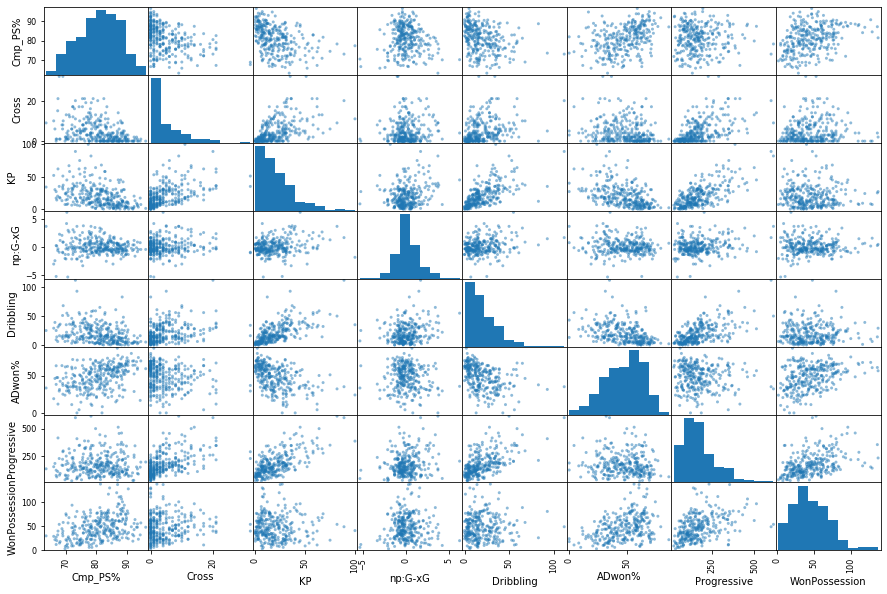

In [90]:
attributes = plotPrint.columns
scatter_matrix(plotPrint[attributes], figsize=(15, 10));

Possiamo notare come non sia presente una forte correlazione tra gli attributi rimasti, per questo motivo non ne eliminiamo altri.

<h2>Clustering</h2>

Sfruttiamo l'elbow method ed il silhouette diagram per scegliere il numero di cluster. 

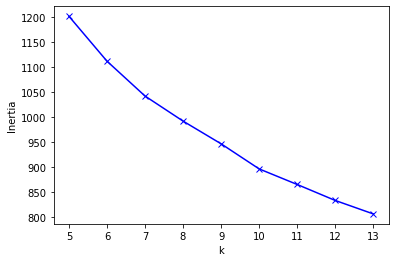

In [91]:
inertia = []
K = range(5,14)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state= 0).fit(dt)
    inertia.append(kmeanModel.inertia_)

#plottiamo l'elbow

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.show()

In [92]:
range_ = range(5, 14)

kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(dt)
                for k in range_]

silhouette_scores = [silhouette_score(dt, model.labels_)
                     for model in kmeans_per_k]

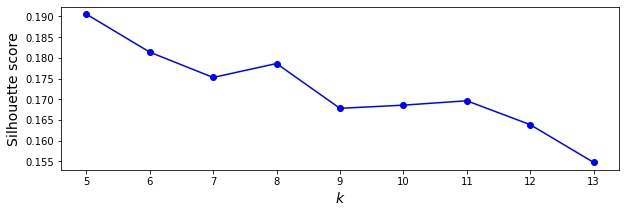

In [93]:
plt.figure(figsize=(10, 3))
plt.plot(range_, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Benchè i grafici non diano indicazioni nette, notiamo in corrispondenza dei valori $8$ e $11$ un miglioramento sia in termini di pendenza del grafico dell'inerzia sia nel silhouette diagram. Scegliamo come valore finale $8$ in quanto più verosimile al numero di ruoli da riconoscere. 

In [94]:
kmeans= KMeans(n_clusters=8, random_state=0)
plotX["cluster"] = kmeans.fit_predict(dt)
kmeans.inertia_

991.5658210213011

In [95]:
plotPrint["cluster"] = plotX["cluster"]
pd.set_option("display.max_rows", None, "display.max_columns", None)
{i:plotPrint.iloc[np.where(kmeans.labels_ == i)] for i in range(kmeans.n_clusters)}

{0:                        Cmp_PS%  Cross    KP  np:G-xG  Dribbling  ADwon%  \
 Adrien Silva              87.5    0.0  10.0      0.6       10.0    33.3   
 Alexis Saelemaekers       80.1    7.0  31.0     -0.9       44.0    21.9   
 AntonÃ­n BarÃ¡k           78.2    4.0  24.0      1.2       31.0    42.7   
 Arthur Melo               94.4    0.0  17.0      0.8       16.0    16.7   
 Artur IoniÈ›Äƒ            78.0    3.0   9.0      0.5       20.0    44.4   
 Brahim DÃ­az              86.8    3.0  19.0      0.7       33.0    16.7   
 Bruno Peres               83.0    7.0  28.0     -0.2       14.0    25.0   
 Diego Demme               89.4    2.0  18.0      0.6        4.0    30.4   
 Diego Farias              81.4    4.0  31.0      0.6       24.0    47.1   
 Franck RibÃ©ry            86.4    2.0  31.0     -1.0       61.0    14.7   
 GastÃ³n Brugman           83.2    0.0  25.0     -0.2       16.0    44.4   
 Gervinho                  81.9    3.0  27.0      0.8       43.0     0.0   
 Giorgos 

<h2>Analisi dei risultati</h2>

Scegliamo di analizzare in particolare le statistiche di $ Razvan \  Marin $ centrocampista del Cagliari. Il giocatore durante l'ultimo campionato è stato schierato davanti alla difesa come centrocampista centrale; tuttavia, dalla nostra analisi risulta che il giocatore non ricade nel cluster con i mediani ( cluster 6 ), ma è inserito nel cluster con giocatori più offensivi (cluster 4), come ad esempio Roberto Soriano (trequartista del Bologna) oppure Hakan Çalhanoğlu (trequartista del Milan).
\
\
Selezioniamo i giocatori più significativi del cluster contenente i **mediani** e di quello con i **trequartisti** in modo da verificare la similarità tra le statistiche di questi ultimi e Marin.

In [96]:
mediani = ["Adrien Rabiot", "Gonzalo Villar", "TiemouÃ© Bakayoko" ,'Manuel Locatelli', 'Marcelo BrozoviÄ‡', "Rodrigo Bentancur"]
trequartisti = ["Piotr ZieliÅ„ski" ,'Hakan Ã‡alhanoÄŸlu',  "Henrikh Mkhitaryan", "Luis Alberto", "Roberto Pereyra" , "Roberto Soriano",]
marin = ["RÄƒzvan Marin"]
player = mediani[3:5] + trequartisti[4:6] + marin[0:2]
plotPrint.loc[player]

,Cmp_PS%,Cross,KP,np:G-xG,Dribbling,ADwon%,Progressive,WonPossession,cluster
Manuel Locatelli,87.5,6.0,41.0,-0.7,24.0,54.6,455.0,95,6
Marcelo BrozoviÄ‡,88.0,10.0,45.0,0.2,11.0,50.0,355.0,75,6
Roberto Pereyra,84.6,3.0,44.0,1.1,36.0,32.4,327.0,43,4
Roberto Soriano,81.2,5.0,48.0,2.8,41.0,36.8,368.0,57,4
RÄƒzvan Marin,81.7,4.0,68.0,1.5,32.0,40.5,275.0,75,4


Confrontiamo le statistiche di Marin con la media delle statistiche dei mediani (cluster 6).

In [97]:
cluster = pd.DataFrame()
Media_Mediani = pd.Series(plotPrint.iloc[np.where(kmeans.labels_ == 6)].mean(), name = "media mediani")
cluster = cluster.append(Media_Mediani)
cluster = cluster.append(plotPrint.loc["RÄƒzvan Marin"])
cluster

,ADwon%,Cmp_PS%,Cross,Dribbling,KP,Progressive,WonPossession,cluster,np:G-xG
media mediani,59.784444,86.12,3.133333,17.222222,15.822222,235.888889,83.977778,6.0,-0.055556
RÄƒzvan Marin,40.500000,81.70,4.000000,32.000000,68.000000,275.000000,75.000000,4.0,1.500000


Possiamo notare dalle statistiche che Marin ha delle caratteristiche più simili a quelle di un trequartista rispetto a quelle dei centrocampisti centrali.
\
Infatti:
- Per quanto riguarda la precisione dei passaggi $( Cmp\_PS\%  ) $, il valore di Marin $(81.7) $ è molto più basso rispetto a quello dei mediani (Locatelli $ 87.5 $, ..) ed alla media del cluster 6 $ ( 86.05 ) $, mentre è simile ad esempio a quello di Roberto Soriano ( $ 81.2$  ).
- Considerando invece i passaggi chiave $(KP)$, cioè i passaggi che portano a un tiro, Marin ha valore notevolmente più alto rispetto a quello dei mediani $(15.82) $.
- Valutando inoltre l'efficacia nei tiri $ ( np:G- xG) $ Marin anche in questo caso ha un valore molto più alto rispetto ai mediani.

Queste ultime due caratteristiche mostrano l'incisività di Marin nelle zone più offensive, dove dovrebbe essere posizionato secondo la nostra analisi.

I valori del centrocampista del Cagliari sono più simili a quelli dei trequartisti; un esempio è visibile nel radar chart riportato sotto, in cui si confronta Marin con Soriano e Locatelli.

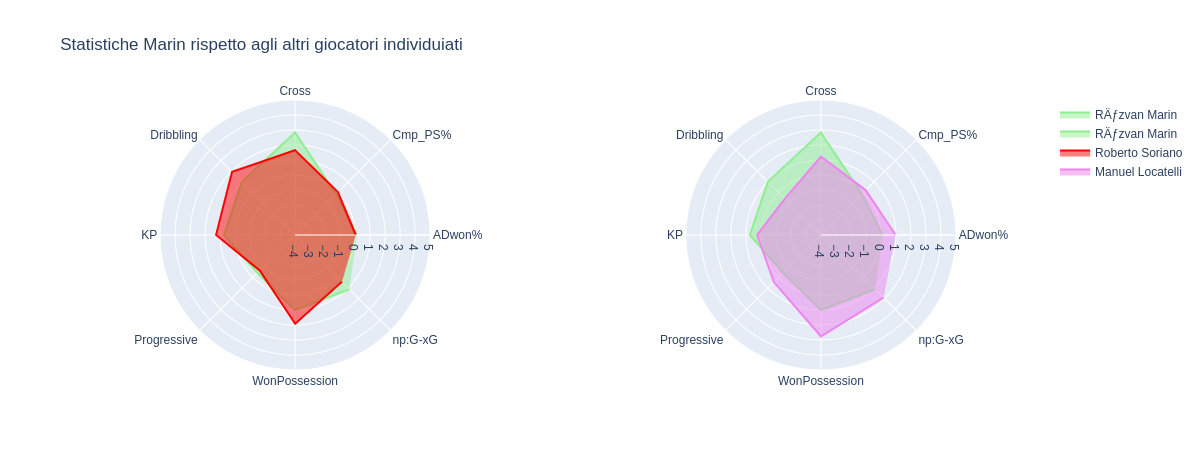

In [98]:
categories = ["ADwon%", "Cmp_PS%" , "Cross" , "Dribbling" , "KP" , "Progressive", "WonPossession" ,"np:G-xG"]
range_ = [-4, 5]

fig = go.Figure()

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}]*2]*1)

fig.add_trace(go.Scatterpolar(
      r=dt.loc["RÄƒzvan Marin"],
      theta=categories,
      fill='toself',
      name='RÄƒzvan Marin', 
    line_color = 'lightgreen', 
    mode='lines'


), row=[1,1], col=[1, 2])


fig.add_trace(go.Scatterpolar(
      r=dt.loc["Roberto Soriano"],
      theta=categories,
      fill='toself',
        line_color = 'red', 

      name='Roberto Soriano	', 
          mode='lines'

), row=1, col=1)

fig.add_trace(go.Scatterpolar(
      r=dt.loc["Manuel Locatelli"],
      theta=categories,
      fill='toself',
    line_color = 'violet', 

      name='Manuel Locatelli', 
          mode='lines'

), row=1, col=2)





fig.update_layout(title="Statistiche Marin rispetto agli altri giocatori individuiati",
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=range_
    )),
    
    polar2=dict(
        radialaxis=dict(
        visible=True,
        range=range_
    ))
)

fig.show(width=1000, height=1000)


Possiamo notare che il radar chart di Marin si sovrappone bene a quello di Soriano (in rosso) mentre si discosta abbastanza da quello di Locatelli (in viola).

Individuati i giocatori di interesse per ognuno dei due ruoli (Mediani e Trequartisti), ne facciamo la media e la confrontiamo con i valori di Marin.

In [99]:
plot_medie = pd.DataFrame()
plot_medie = plot_medie.append(pd.Series(dt.loc[mediani].mean(axis=0)), ignore_index=True)
plot_medie = plot_medie.append(pd.Series(dt.loc[trequartisti].mean(axis=0)), ignore_index=True)
plot_medie = plot_medie.append(pd.Series(dt.loc[marin].mean(axis=0)), ignore_index=True)

plot_medie = plot_medie.rename(index={0: "Mediani", 1:"Trequartisti", 2:"Marin"})

plot_medie

,ADwon%,Cmp_PS%,Cross,Dribbling,KP,Progressive,WonPossession,np:G-xG
Mediani,0.512119,1.235888,-0.080098,0.217608,0.241085,1.036616,1.271414,-0.039914
Trequartisti,-1.062276,-0.121946,0.188393,1.422190,2.581037,2.073625,0.151446,0.997673
Marin,-0.434785,0.120168,-0.139762,0.729556,2.838828,0.998937,1.120775,1.009738


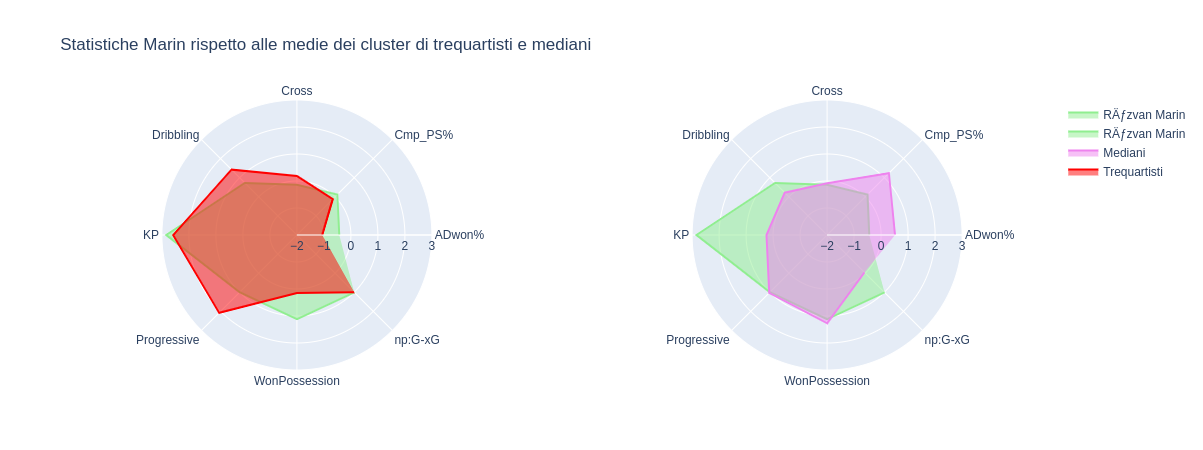

In [100]:
fig2 = go.Figure()
range_ = [-2, 3]

fig2 = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}]*2]*1)

fig2.add_trace(go.Scatterpolar(
      r=plot_medie.loc["Marin"],
      theta=categories,
      fill='toself',
      name='RÄƒzvan Marin', 
    line_color = 'lightgreen', 
    mode='lines'


), row=[1,1], col=[1, 2])


fig2.add_trace(go.Scatterpolar(
      r=plot_medie.loc["Mediani"],
      theta=categories,
      fill='toself',
      name='Mediani',
      line_color = 'violet', 
      mode='lines'
      ), row=1, col=2)

fig2.add_trace(go.Scatterpolar(
      r=plot_medie.loc["Trequartisti"],
      theta=categories,
      fill='toself',
      name='Trequartisti',
    line_color = 'red', 

      mode='lines'
      ), row=1, col=1)

fig2.update_layout(title="Statistiche Marin rispetto alle medie dei cluster di trequartisti e mediani",
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=range_
    )),
 
    polar2=dict(
        radialaxis=dict(
        visible=True,
        range=range_
    ))
)

fig2.show(width=1000, height=1000)


Il grafico di Marin è molto simile a quello dei trequartisti (in rosso) mentre presenta notevoli differenze rispetto a quello dei mediani (in viola).

<h4>Conclusione</h4>

Dalla nostra analisi risulta che le statistiche di Marin fanno di lui un giocatore molto più adatto a giocare come trequartista piuttosto che come mediano davanti alla difesa.